In [13]:
from log_parser import parse_keyboard_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample
seg_length = 100

# List of parsed logfiles
keyboard = []
keyboard.append(parse_keyboard_log("./logs/JON/SPY/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/MAR/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/HEN/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/ZIR/SOL/keyboard_actions.log"))

# Empty lists for inserting data
X_actual = []
Y_actual = []

for k in range(len(keyboard)):
    for i in range(int(keyboard[k].time.iloc[-1] / seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, seg_length)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())

print(f"Data samples: {len(Y_actual)}")


Data samples: 145


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=0)

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( 
    f"Train score: {rfc.score(X_train, Y_train)} " +
    f"Test score: {rfc.score(X_test, Y_test)}"
)

# Predict on test set
Y_predict = rfc.predict(X_test)

# Ouput predictions vs ground truth values
for i in range(len(Y_predict)):
    print(f"Actual: {Y_test[i]:<10}  -  Predicted: {Y_predict[i]}")

Train score: 1.0 Test score: 1.0
Actual: JONSPY      -  Predicted: JONSPY
Actual: JONSPY      -  Predicted: JONSPY
Actual: JONSPY      -  Predicted: JONSPY
Actual: MARSOL      -  Predicted: MARSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: MARSOL      -  Predicted: MARSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: HENSOL      -  Predicted: HENSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: HENSOL      -  P

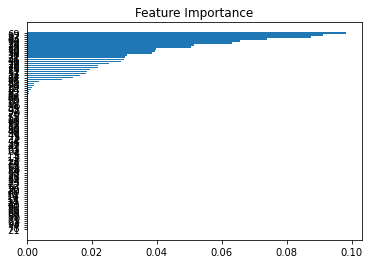

In [15]:
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
indices = np.argsort(importances)

# names = [magicFunctionThatGivesNames() for i in indices]

# Barplot
plt.barh(range(len(indices)), importances[indices])
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(indices)), [indices[i] for i in indices])
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(448.6842105263157, 570.4444444444445, 'X[59] <= 0.005\ngini = 0.746\nsamples = 72\nvalue = [26, 22, 28, 32]'),
 Text(342.6315789473684, 503.3333333333333, 'X[9] <= 1.091\ngini = 0.732\nsamples = 64\nvalue = [24, 14, 27, 32]'),
 Text(309.99999999999994, 436.22222222222223, 'X[12] <= 0.083\ngini = 0.717\nsamples = 58\nvalue = [14, 14, 27, 32]'),
 Text(195.78947368421052, 369.1111111111111, 'X[65] <= 0.033\ngini = 0.469\nsamples = 31\nvalue = [8, 0, 6, 32]'),
 Text(163.15789473684208, 302.0, 'X[8] <= 0.727\ngini = 0.32\nsamples = 27\nvalue = [8, 0, 0, 32]'),
 Text(97.89473684210526, 234.88888888888886, 'X[8] <= 0.715\ngini = 0.465\nsamples = 13\nvalue = [7, 0, 0, 12]'),
 Text(65.26315789473684, 167.77777777777777, 'X[3] <= 0.105\ngini = 0.415\nsamples = 12\nvalue = [5, 0, 0, 12]'),
 Text(32.63157894736842, 100.66666666666663, 'gini = 0.0\nsamples = 1\nvalue = [2, 0, 0, 0]'),
 Text(97.89473684210526, 100.66666666666663, 'X[91] <= 0.655\ngini = 0.32\nsamples = 11\nvalue = [3, 0, 0, 12

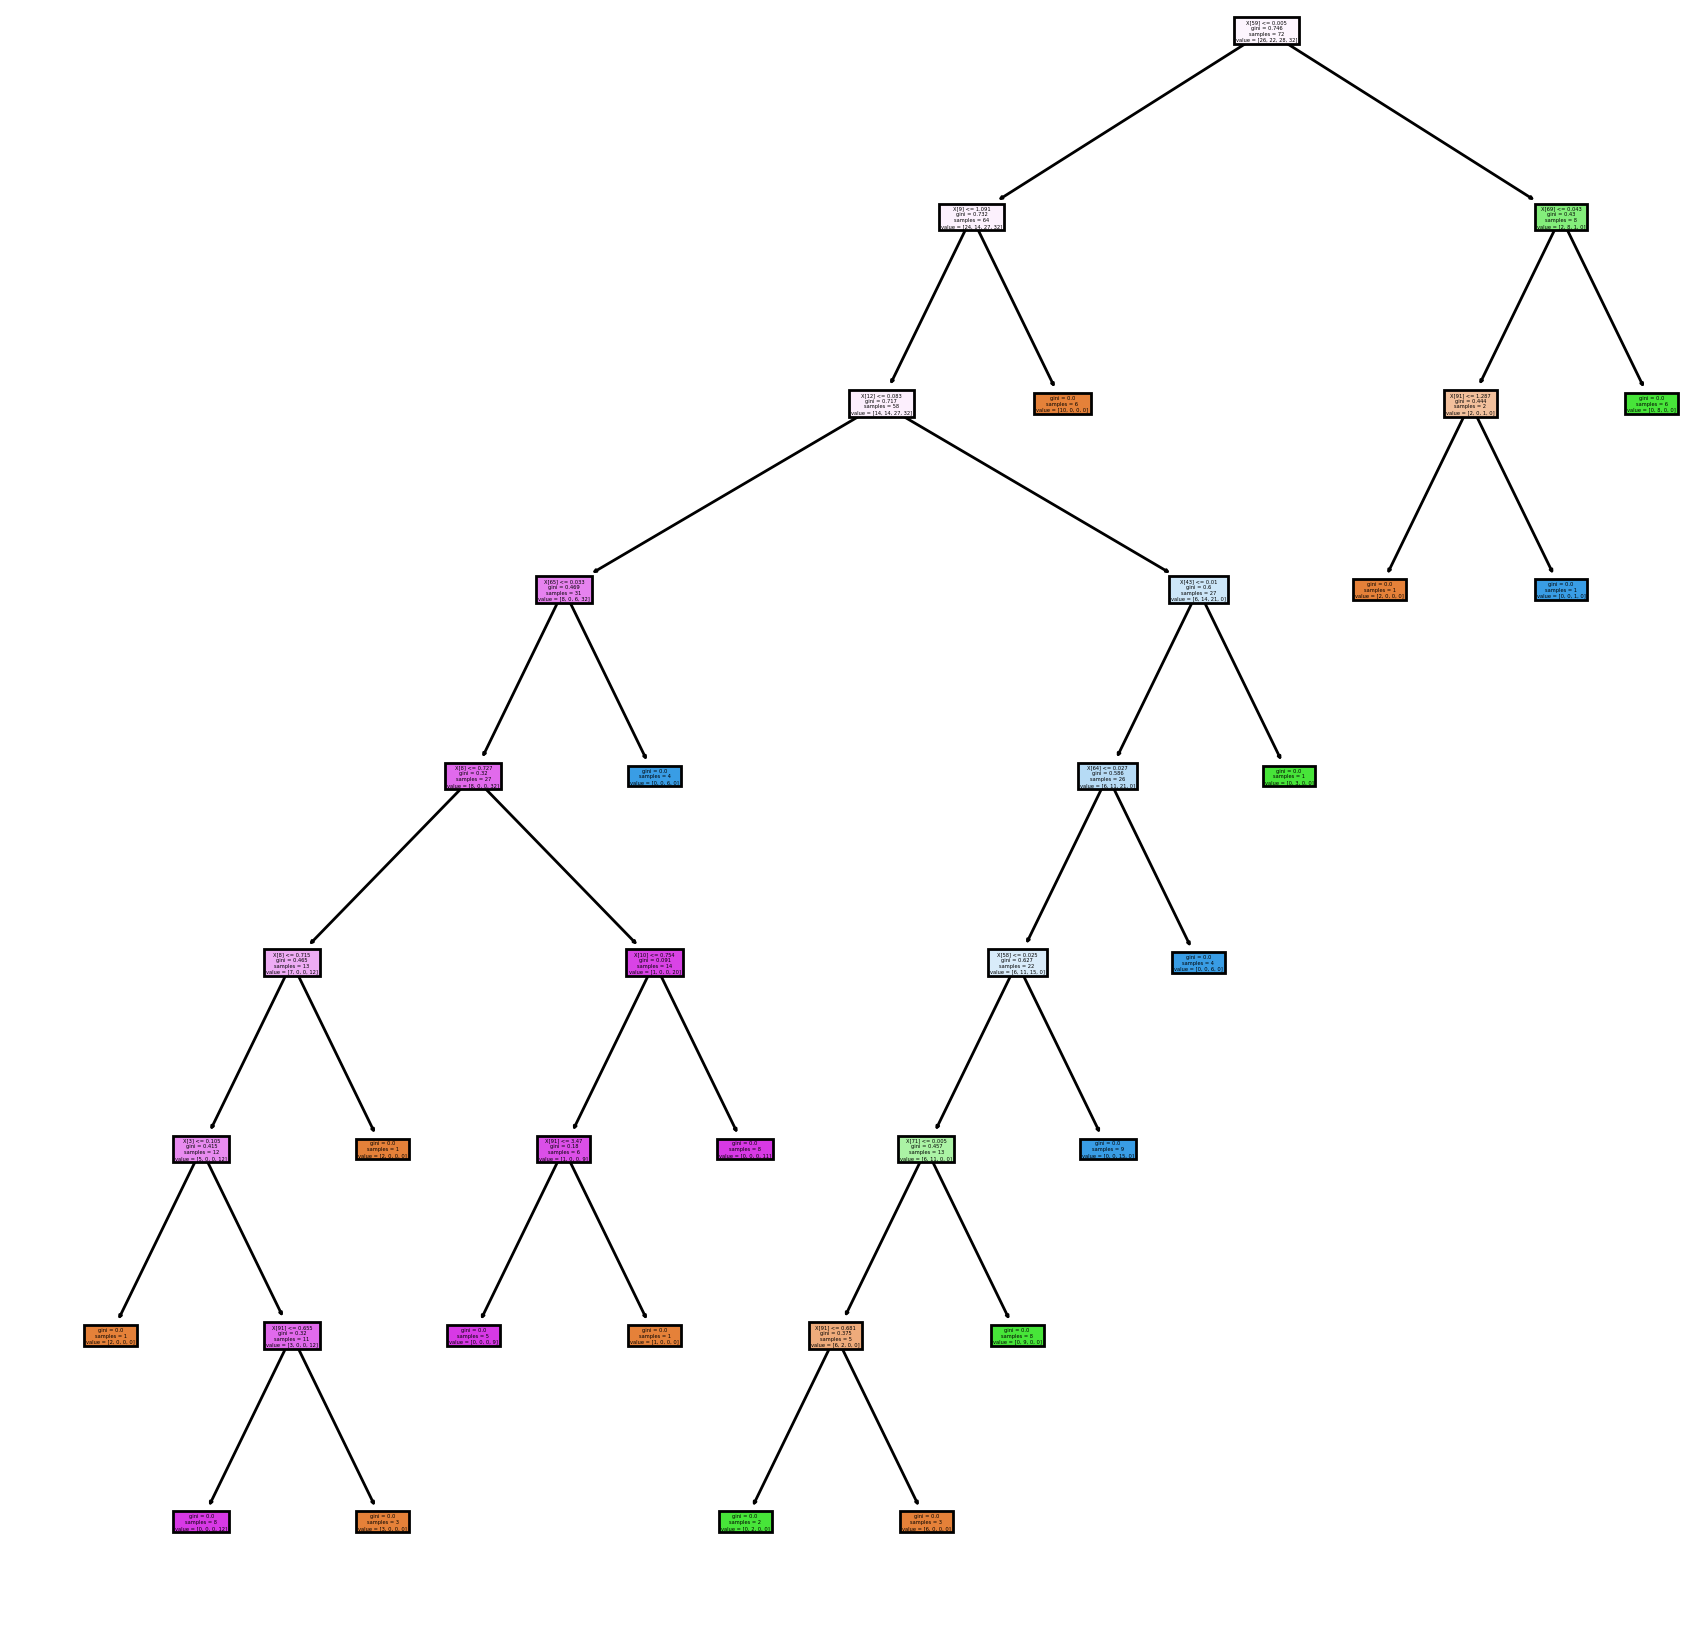

In [16]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], filled = True)